# Library import

In [13]:
# 필요 library들을 import합니다.
import os
from typing import Tuple, Any, Callable, List, Optional, Union

import cv2
import timm
import torch
import numpy as np
import pandas as pd
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt

from torchcam.methods import GradCAM
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2

In [14]:
print(torch.cuda.is_available())

True


# Dataset Class

In [15]:
class CustomDataset(Dataset):
    def __init__(
        self, 
        root_dir: str, 
        info_df: pd.DataFrame, 
        transform: Callable,
        is_inference: bool = False
    ):
        # 데이터셋의 기본 경로, 이미지 변환 방법, 이미지 경로 및 레이블을 초기화합니다.
        self.root_dir = root_dir  # 이미지 파일들이 저장된 기본 디렉토리
        self.transform = transform  # 이미지에 적용될 변환 처리
        self.is_inference = is_inference # 추론인지 확인
        self.image_paths = info_df['image_path'].tolist()  # 이미지 파일 경로 목록
        
        if not self.is_inference:
            self.targets = info_df['target'].tolist()  # 각 이미지에 대한 레이블 목록

    def __len__(self) -> int:
        # 데이터셋의 총 이미지 수를 반환합니다.
        return len(self.image_paths)

    def __getitem__(self, index: int) -> Union[Tuple[torch.Tensor, int], torch.Tensor]:
        # 주어진 인덱스에 해당하는 이미지를 로드하고 변환을 적용한 후, 이미지와 레이블을 반환합니다.
        img_path = os.path.join(self.root_dir, self.image_paths[index])  # 이미지 경로 조합
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # 이미지를 BGR 컬러 포맷의 numpy array로 읽어옵니다.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR 포맷을 RGB 포맷으로 변환합니다.
        image = self.transform(image)  # 설정된 이미지 변환을 적용합니다.

        if self.is_inference:
            return image
        else:
            target = self.targets[index]  # 해당 이미지의 레이블
            return image, target  # 변환된 이미지와 레이블을 튜플 형태로 반환합니다. 

# Transform Class

In [16]:
class TorchvisionTransform:
    def __init__(self, is_train: bool = True):
        # 공통 변환 설정: 이미지 리사이즈, 텐서 변환, 정규화
        common_transforms = [
            transforms.Resize((224, 224)),  # 이미지를 224x224 크기로 리사이즈
            transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
        ]
        
        if is_train:
            # 훈련용 변환: 랜덤 수평 뒤집기, 랜덤 회전, 색상 조정 추가
            self.transform = transforms.Compose(
                [
                    transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 이미지를 수평 뒤집기
                    transforms.RandomRotation(15),  # 최대 15도 회전
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 밝기 및 대비 조정
                ] + common_transforms
            )
        else:
            # 검증/테스트용 변환: 공통 변환만 적용
            self.transform = transforms.Compose(common_transforms)

    def __call__(self, image: np.ndarray) -> torch.Tensor:
        image = Image.fromarray(image)  # numpy 배열을 PIL 이미지로 변환
        
        transformed = self.transform(image)  # 설정된 변환을 적용
        
        return transformed  # 변환된 이미지 반환

In [17]:
class AlbumentationsTransform:
    def __init__(self, is_train: bool = True):
        # 공통 변환 설정: 이미지 리사이즈, 정규화, 텐서 변환
        common_transforms = [
            A.Resize(224, 224),  # 이미지를 224x224 크기로 리사이즈
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 정규화
            ToTensorV2()  # albumentations에서 제공하는 PyTorch 텐서 변환
        ]
        
        if is_train:
            # 훈련용 변환: 랜덤 수평 뒤집기, 랜덤 회전, 랜덤 밝기 및 대비 조정 추가
            self.transform = A.Compose(
                [
                    A.HorizontalFlip(p=0.5),  # 50% 확률로 이미지를 수평 뒤집기
                    A.Rotate(limit=15),  # 최대 15도 회전
                    A.RandomBrightnessContrast(p=0.2),  # 밝기 및 대비 무작위 조정
                ] + common_transforms
            )
        else:
            # 검증/테스트용 변환: 공통 변환만 적용
            self.transform = A.Compose(common_transforms)

    def __call__(self, image) -> torch.Tensor:
        # 이미지가 NumPy 배열인지 확인
        if not isinstance(image, np.ndarray):
            raise TypeError("Image should be a NumPy array (OpenCV format).")
        
        # 이미지에 변환 적용 및 결과 반환
        transformed = self.transform(image=image)  # 이미지에 설정된 변환을 적용
        
        return transformed['image']  # 변환된 이미지의 텐서를 반환

In [18]:
class TransformSelector:
    """
    이미지 변환 라이브러리를 선택하기 위한 클래스.
    """
    def __init__(self, transform_type: str):

        # 지원하는 변환 라이브러리인지 확인
        if transform_type in ["torchvision", "albumentations"]:
            self.transform_type = transform_type
        
        else:
            raise ValueError("Unknown transformation library specified.")

    def get_transform(self, is_train: bool):
        
        # 선택된 라이브러리에 따라 적절한 변환 객체를 생성
        if self.transform_type == 'torchvision':
            transform = TorchvisionTransform(is_train=is_train)
        
        elif self.transform_type == 'albumentations':
            transform = AlbumentationsTransform(is_train=is_train)
        
        return transform

# Model Class

In [19]:
class SimpleCNN(nn.Module):
    """
    간단한 CNN 아키텍처를 정의하는 클래스.
    """
    def __init__(self, num_classes: int):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        # 순전파 함수 정의
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [20]:
class TorchvisionModel(nn.Module):
    """
    Torchvision에서 제공하는 사전 훈련된 모델을 사용하는 클래스.
    """
    def __init__(
        self, 
        model_name: str, 
        num_classes: int, 
        pretrained: bool
    ):
        super(TorchvisionModel, self).__init__()
        self.model = models.__dict__[model_name](pretrained=pretrained)
        
        # 모델의 최종 분류기 부분을 사용자 정의 클래스 수에 맞게 조정
        if 'fc' in dir(self.model):
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, num_classes)
        
        elif 'classifier' in dir(self.model):
            num_ftrs = self.model.classifier[-1].in_features
            self.model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        return self.model(x)

In [21]:
class TimmModel(nn.Module):
    """
    Timm 라이브러리를 사용하여 다양한 사전 훈련된 모델을 제공하는 클래스.
    """
    def __init__(
        self, 
        model_name: str, 
        num_classes: int, 
        pretrained: bool
    ):
        super(TimmModel, self).__init__()
        self.model = timm.create_model(
            model_name, 
            pretrained=pretrained, 
            num_classes=num_classes
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        return self.model(x)

In [22]:
class ModelSelector:
    """
    사용할 모델 유형을 선택하는 클래스.
    """
    def __init__(
        self, 
        model_type: str, 
        num_classes: int, 
        **kwargs
    ):
        
        # 모델 유형에 따라 적절한 모델 객체를 생성
        if model_type == 'simple':
            self.model = SimpleCNN(num_classes=num_classes)
        
        elif model_type == 'torchvision':
            self.model = TorchvisionModel(num_classes=num_classes, **kwargs)
        
        elif model_type == 'timm':
            self.model = TimmModel(num_classes=num_classes, **kwargs)
        
        else:
            raise ValueError("Unknown model type specified.")

    def get_model(self) -> nn.Module:

        # 생성된 모델 객체 반환
        return self.model

# Loss Class

In [23]:
class Loss(nn.Module):
    """
    모델의 손실함수를 계산하는 클래스.
    """
    def __init__(self):
        super(Loss, self).__init__()
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(
        self, 
        outputs: torch.Tensor, 
        targets: torch.Tensor
    ) -> torch.Tensor:
    
        return self.loss_fn(outputs, targets)

# Trainer Class

In [24]:
class Trainer:
    def __init__(
        self, 
        model: nn.Module, 
        device: torch.device, 
        train_loader: DataLoader, 
        val_loader: DataLoader, 
        optimizer: optim.Optimizer,
        scheduler: optim.lr_scheduler,
        loss_fn: torch.nn.modules.loss._Loss, 
        epochs: int,
        result_path: str
    ):
        # 클래스 초기화: 모델, 디바이스, 데이터 로더 등 설정
        self.model = model  # 훈련할 모델
        self.device = device  # 연산을 수행할 디바이스 (CPU or GPU)
        self.train_loader = train_loader  # 훈련 데이터 로더
        self.val_loader = val_loader  # 검증 데이터 로더
        self.optimizer = optimizer  # 최적화 알고리즘
        self.scheduler = scheduler # 학습률 스케줄러
        self.loss_fn = loss_fn  # 손실 함수
        self.epochs = epochs  # 총 훈련 에폭 수
        self.result_path = result_path  # 모델 저장 경로
        self.best_models = [] # 가장 좋은 상위 3개 모델의 정보를 저장할 리스트
        self.lowest_loss = float('inf') # 가장 낮은 Loss를 저장할 변수

    def save_model(self, epoch, loss):
        # 모델 저장 경로 설정
        os.makedirs(self.result_path, exist_ok=True)

        # 현재 에폭 모델 저장
        current_model_path = os.path.join(self.result_path, f'model_epoch_{epoch}_loss_{loss:.4f}.pt')
        torch.save(self.model.state_dict(), current_model_path)

        # 최상위 3개 모델 관리
        self.best_models.append((loss, epoch, current_model_path))
        self.best_models.sort()
        if len(self.best_models) > 3:
            _, _, path_to_remove = self.best_models.pop(-1)  # 가장 높은 손실 모델 삭제
            if os.path.exists(path_to_remove):
                os.remove(path_to_remove)

        # 가장 낮은 손실의 모델 저장
        if loss < self.lowest_loss:
            self.lowest_loss = loss
            best_model_path = os.path.join(self.result_path, 'best_model.pt')
            torch.save(self.model.state_dict(), best_model_path)
            print(f"Save {epoch}epoch result. Loss = {loss:.4f}")

    def train_epoch(self) -> float:
        # 한 에폭 동안의 훈련을 진행
        self.model.train()
        
        total_loss = 0.0
        progress_bar = tqdm(self.train_loader, desc="Training", leave=False)
        
        for images, targets in progress_bar:
            images, targets = images.to(self.device), targets.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.loss_fn(outputs, targets)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
        
        return total_loss / len(self.train_loader)

    def validate(self) -> float:
        # 모델의 검증을 진행
        self.model.eval()
        
        total_loss = 0.0
        progress_bar = tqdm(self.val_loader, desc="Validating", leave=False)
        
        with torch.no_grad():
            for images, targets in progress_bar:
                images, targets = images.to(self.device), targets.to(self.device)
                outputs = self.model(images)    
                loss = self.loss_fn(outputs, targets)
                total_loss += loss.item()
                progress_bar.set_postfix(loss=loss.item())
        
        return total_loss / len(self.val_loader)

    def train(self) -> None:
        # 전체 훈련 과정을 관리
        for epoch in range(self.epochs):
            print(f"Epoch {epoch+1}/{self.epochs}")
            
            train_loss = self.train_epoch()
            val_loss = self.validate()
            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}\n")

            self.save_model(epoch, val_loss)
            self.scheduler.step()

# Model Training

In [25]:
# 학습에 사용할 장비를 선택.
# torch라이브러리에서 gpu를 인식할 경우, cuda로 설정.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
# 학습 데이터의 경로와 정보를 가진 파일의 경로를 설정.
traindata_dir = "./data/train"
traindata_info_file = "./data/train.csv"
save_result_path = "./train_result"

In [27]:
# 학습 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기.
train_info = pd.read_csv(traindata_info_file)

# 총 class의 수를 측정.
num_classes = len(train_info['target'].unique())

# 각 class별로 8:2의 비율이 되도록 학습과 검증 데이터를 분리.
train_df, val_df = train_test_split(
    train_info, 
    test_size=0.2,
    stratify=train_info['target']
)

In [28]:
# 학습에 사용할 Transform을 선언.
transform_selector = TransformSelector(
    transform_type = "albumentations"
)
train_transform = transform_selector.get_transform(is_train=True)
val_transform = transform_selector.get_transform(is_train=False)

# 학습에 사용할 Dataset을 선언.
train_dataset = CustomDataset(
    root_dir=traindata_dir,
    info_df=train_df,
    transform=train_transform
)
val_dataset = CustomDataset(
    root_dir=traindata_dir,
    info_df=val_df,
    transform=val_transform
)

# 학습에 사용할 DataLoader를 선언.
train_loader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=64, 
    shuffle=False
)

In [29]:
# 학습에 사용할 Model을 선언.
model_selector = ModelSelector(
    model_type='timm', 
    num_classes=num_classes,
    model_name='resnet18', 
    pretrained=True
)
model = model_selector.get_model()

# 선언된 모델을 학습에 사용할 장비로 셋팅.
model.to(device)

TimmModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [30]:
# 학습에 사용할 optimizer를 선언하고, learning rate를 지정
optimizer = optim.Adam(
    model.parameters(), 
    lr=0.001
)

In [31]:
# 스케줄러 초기화
scheduler_step_size = 30  # 매 30step마다 학습률 감소
scheduler_gamma = 0.1  # 학습률을 현재의 10%로 감소

# 한 epoch당 step 수 계산
steps_per_epoch = len(train_loader)

# 2 epoch마다 학습률을 감소시키는 스케줄러 선언
epochs_per_lr_decay = 2
scheduler_step_size = steps_per_epoch * epochs_per_lr_decay

scheduler = optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=scheduler_step_size, 
    gamma=scheduler_gamma
)

In [32]:
# 학습에 사용할 Loss를 선언.
loss_fn = Loss()

In [33]:
# 앞서 선언한 필요 class와 변수들을 조합해, 학습을 진행할 Trainer를 선언. 
trainer = Trainer(
    model=model, 
    device=device, 
    train_loader=train_loader,
    val_loader=val_loader, 
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn, 
    epochs=5,
    result_path=save_result_path
)

In [34]:
# 모델 학습.
trainer.train()

Epoch 1/5


Epoch 1, Train Loss: 4.7924, Validation Loss: 2.8944

Save 0epoch result. Loss = 2.8944
Epoch 2/5


Epoch 2, Train Loss: 2.0074, Validation Loss: 1.8489

Save 1epoch result. Loss = 1.8489
Epoch 3/5


Epoch 3, Train Loss: 1.0672, Validation Loss: 1.4136

Save 2epoch result. Loss = 1.4136
Epoch 4/5


Epoch 4, Train Loss: 0.9059, Validation Loss: 1.3344

Save 3epoch result. Loss = 1.3344
Epoch 5/5


Epoch 5, Train Loss: 0.8148, Validation Loss: 1.3215

Save 4epoch result. Loss = 1.3215


# Inference

In [35]:
# 모델 추론을 위한 함수
def inference(
    model: nn.Module, 
    device: torch.device, 
    test_loader: DataLoader
):
    # 모델을 평가 모드로 설정
    model.to(device)
    model.eval()
    
    predictions = []
    with torch.no_grad():  # Gradient 계산을 비활성화
        for images in tqdm(test_loader):
            # 데이터를 같은 장치로 이동
            images = images.to(device)
            
            # 모델을 통해 예측 수행
            logits = model(images)
            logits = F.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)
            
            # 예측 결과 저장
            predictions.extend(preds.cpu().detach().numpy())  # 결과를 CPU로 옮기고 리스트에 추가
    
    return predictions

In [36]:
# 추론 데이터의 경로와 정보를 가진 파일의 경로를 설정.
testdata_dir = "./data/test"
testdata_info_file = "./data/test.csv"
save_result_path = "./train_result"

In [37]:
# 추론 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기.
test_info = pd.read_csv(testdata_info_file)

# 총 class 수.
num_classes = 500

In [38]:
# 추론에 사용할 Transform을 선언.
transform_selector = TransformSelector(
    transform_type = "albumentations"
)
test_transform = transform_selector.get_transform(is_train=False)

# 추론에 사용할 Dataset을 선언.
test_dataset = CustomDataset(
    root_dir=testdata_dir,
    info_df=test_info,
    transform=test_transform,
    is_inference=True
)

# 추론에 사용할 DataLoader를 선언.
test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False,
    drop_last=False
)

In [39]:
# 추론에 사용할 장비를 선택.
# torch라이브러리에서 gpu를 인식할 경우, cuda로 설정.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 추론에 사용할 Model을 선언.
model_selector = ModelSelector(
    model_type='timm', 
    num_classes=num_classes,
    model_name='resnet18', 
    pretrained=False
)
model = model_selector.get_model()


In [40]:
# best epoch 모델을 불러오기.
model.load_state_dict(
    torch.load(
        os.path.join(save_result_path, "best_model.pt"),
        map_location='cpu'
    )
)

/tmp/ipykernel_609822/1021875342.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


<All keys matched successfully>

In [41]:
# predictions를 CSV에 저장할 때 형식을 맞춰서 저장
# 테스트 함수 호출
predictions = inference(
    model=model, 
    device=device, 
    test_loader=test_loader
)

100%|██████████| 157/157 [02:00<00:00,  1.30it/s]


In [42]:
# 모든 클래스에 대한 예측 결과를 하나의 문자열로 합침
test_info['target'] = predictions
test_info = test_info.reset_index().rename(columns={"index": "ID"})
test_info

,ID,image_path,target
0,0,0.JPEG,328
1,1,1.JPEG,414
2,2,2.JPEG,205
3,3,3.JPEG,17
4,4,4.JPEG,388
...,...,...,...
10009,10009,10009.JPEG,235
10010,10010,10010.JPEG,111
10011,10011,10011.JPEG,219
10012,10012,10012.JPEG,400


In [43]:
# DataFrame 저장
test_info.to_csv("output.csv", index=False)

In [44]:
def visualize_gradcam(
        model: torch.nn.Module,
        device: torch.device,
        dataloader: DataLoader,
        target_layer: str,
        image_index: int
    ):

    # Grad-CAM 추출기를 초기화합니다.
    cam_extractor = GradCAM(model, target_layer)
    
    model.eval()  # 모델을 평가 모드로 설정합니다.
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 시각화를 위한 Figure를 생성합니다.
    
    # 데이터 로더에서 배치를 반복합니다.
    current_index = 0
    for inputs in dataloader:
        inputs = inputs.to(device)  # 입력 이미지를 장치로 이동합니다.
        
        outputs = model(inputs)  # 모델을 통해 예측을 수행합니다.
        _, preds = torch.max(outputs, 1)  # 예측된 클래스 인덱스를 가져옵니다.
        
        # 배치 내의 각 이미지에 대해 처리합니다.
        for j in range(inputs.size()[0]):
            if current_index == image_index:
                # CAM을 가져옵니다.
                cam = cam_extractor(preds[j].item(), outputs[j].unsqueeze(0))[0]
                # CAM을 1채널로 변환합니다.
                cam = cam.mean(dim=0).cpu().numpy()
                
                # CAM을 원본 이미지 크기로 리사이즈합니다.
                cam = cv2.resize(cam, (inputs[j].shape[2], inputs[j].shape[1]))
                
                # CAM을 정규화합니다.
                cam = (cam - cam.min()) / (cam.max() - cam.min())  # 정규화
                ㅈ
                # CAM을 0-255 범위로 변환합니다.
                cam = np.uint8(255 * cam)
                # 컬러맵을 적용하여 RGB 이미지로 변환합니다.
                cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
                cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)  # BGR에서 RGB로 변환
                
                # 입력 이미지가 1채널 또는 3채널인지 확인하고 처리합니다.
                input_image = inputs[j].cpu().numpy().transpose((1, 2, 0))
                if input_image.shape[2] == 1:  # 1채널 이미지인 경우
                    input_image = np.squeeze(input_image, axis=2)  # (H, W, 1) -> (H, W)
                    input_image = np.stack([input_image] * 3, axis=-1)  # (H, W) -> (H, W, 3)로 변환하여 RGB처럼 만듭니다.
                else:  # 3채널 이미지인 경우
                    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
                    input_image = (input_image * 255).astype(np.uint8)  # 정규화된 이미지를 8비트 이미지로 변환합니다.
                
                # 오리지널 이미지
                axes[0].imshow(input_image)
                axes[0].set_title("Original Image")
                axes[0].axis('off')
                
                # Grad-CAM 이미지
                axes[1].imshow(cam)
                axes[1].set_title("Grad-CAM Image")
                axes[1].axis('off')
                
                # 오버레이된 이미지 생성
                overlay = cv2.addWeighted(input_image, 0.5, cam, 0.5, 0)
                axes[2].imshow(overlay)
                axes[2].set_title("Overlay Image")
                axes[2].axis('off')
                
                plt.show()  # 시각화를 표시합니다.
                return
            current_index += 1

In [45]:
print(model)

TimmModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

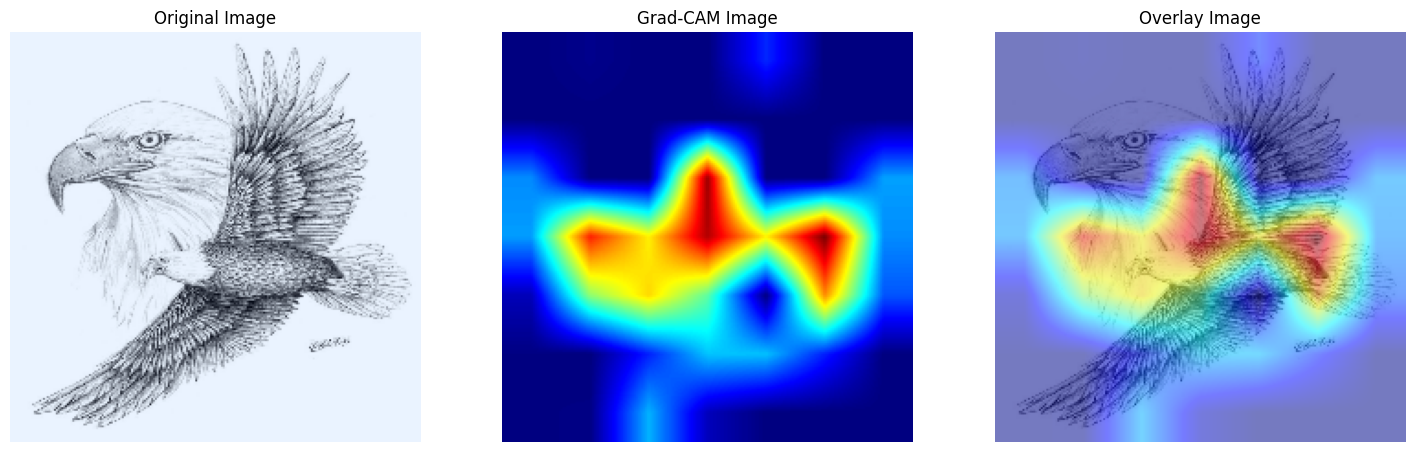

In [46]:
target_layer = 'layer4.1.act2'

# Grad-CAM 시각화 실행 (예: 인덱스 3의 이미지를 시각화)

image_index = 3

visualize_gradcam(model.model, device, test_loader, target_layer=target_layer, image_index=image_index)